<a href="https://colab.research.google.com/github/emchan4/CIND820-medical-no-show-prediction/blob/main/CIND820InitialResultsandCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIND820 Capstone Project: Predicting Medical Appointment No-Shows

This notebook presents the initial results and code for predicting medical appointment no-shows using machine learning classification techniques. The dataset includes patient demographics, scheduling intervals, and time slot allocations. The goal is to identify key predictors of no-shows and evaluate model performance.

In [2]:
#Code Block 1

# -*- coding: utf-8 -*-
"""
CIND820 Capstone Project: Predicting Medical Appointment No-Shows
This imports all required libraries for data analysis, preprocessing, modeling, and evaluation.
"""

# -------------------------------
# Data Manipulation and Visualization
# -------------------------------
import pandas as pd                # For data loading, cleaning, and manipulation
import matplotlib.pyplot as plt    # For creating plots and visualizations
import seaborn as sns              # For advanced statistical visualizations

# -------------------------------
# Machine Learning Models
# -------------------------------
from sklearn.linear_model import LogisticRegression        # Baseline classification model
from sklearn.tree import DecisionTreeClassifier            # Tree-based model for interpretability
from sklearn.ensemble import RandomForestClassifier        # Ensemble model for improved accuracy
from xgboost import XGBClassifier                          # Gradient boosting model for high performance

# -------------------------------
# Model Selection and Evaluation
# -------------------------------
from sklearn.model_selection import train_test_split, cross_val_score  # Train-test split and cross-validation
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)               # Performance metrics

# -------------------------------
# Preprocessing and Imbalanced Data Handling
# -------------------------------
from sklearn.impute import SimpleImputer        # For handling missing values
from sklearn.preprocessing import StandardScaler # For feature scaling
from imblearn.over_sampling import SMOTE        # For addressing class imbalance

# -------------------------------
# Utilities
# -------------------------------
from tabulate import tabulate                   # For formatted output tables

# -------------------------------
# Environment Information (Optional for reproducibility)
# -------------------------------
import sys
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")
print(f"XGBoost version: {__import__('xgboost').__version__}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas version: 2.2.2
Scikit-learn version: 1.6.1
XGBoost version: 3.1.1


## Data Loading and Exploration

We begin by loading the synthetic medical appointment dataset, which includes three CSV files:
- `appointments.csv`: Appointment details and attendance status.
- `patients.csv`: Patient demographics.
- `slots.csv`: Time slot availability.

We then explore the data using summary statistics and visualizations.

In [3]:
# Code Block 2
"""
Code Block 2: Dataset Download and Loading
This block checks for dataset files, downloads them if missing, and loads them into pandas DataFrames.
"""

import os
import zipfile
import requests

# Define file names and URL
DATA_URL = "https://raw.githubusercontent.com/emchan4/CIND820-medical-no-show-prediction/main/Dataset/Medical_Appt_Scheduling_Data.zip"
ZIP_FILE = "Medical_Appt_Scheduling_Data.zip"
FILES = ["appointments.csv", "patients.csv", "slots.csv"]

def download_and_extract(url, zip_path):
    """Download and extract dataset zip file."""
    try:
        print("Downloading dataset...")
        response = requests.get(url)
        response.raise_for_status()
        with open(zip_path, "wb") as f:
            f.write(response.content)
        print("Extracting files...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall()
        print("Download and extraction completed.")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        raise

# Check if all files exist
if not all(os.path.exists(file) for file in FILES):
    download_and_extract(DATA_URL, ZIP_FILE)
else:
    print("Dataset already exists. Skipping download.")

# Load CSV files into DataFrames
try:
    appointments = pd.read_csv("appointments.csv")
    patients = pd.read_csv("patients.csv")
    slots = pd.read_csv("slots.csv")
    print("\nFiles loaded successfully.")
except Exception as e:
    print(f"Error loading files: {e}")
    raise

# Preview datasets
for name, df in zip(["Appointments", "Patients", "Slots"], [appointments, patients, slots]):
    print(f"\n{name} Dataset: Shape = {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(df.head(3))

Extracting files...
Download and extraction completed.

Files loaded successfully.

Appointments Dataset: Shape = (111488, 16)
Columns: ['appointment_id', 'slot_id', 'scheduling_date', 'appointment_date', 'appointment_time', 'scheduling_interval', 'status', 'check_in_time', 'appointment_duration', 'start_time', 'end_time', 'waiting_time', 'patient_id', 'sex', 'age', 'age_group']
   appointment_id  slot_id scheduling_date appointment_date appointment_time  \
0             138        1      2014-12-28       2015-01-01         08:00:00   
1             146       23      2014-12-29       2015-01-01         13:30:00   
2              21       24      2014-12-17       2015-01-01         13:45:00   

   scheduling_interval          status check_in_time  appointment_duration  \
0                    4  did not attend           NaN                   NaN   
1                    3  did not attend           NaN                   NaN   
2                   15        attended      13:36:45           

In [4]:
#Code Block 3
"""
Code Block 3: Dataset Summary and Quality Checks
This block generates descriptive statistics, checks for missing values, and provides quick insights for all datasets.
"""

from tabulate import tabulate

def summarize_dataset(name, df):
    """Print summary statistics and missing value info for a given DataFrame."""
    print(f"\n{'='*40}\n{name} Dataset Summary\n{'='*40}")

    # Shape and columns
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}\n")

    # Descriptive statistics
    print("Descriptive Statistics:")
    print(tabulate(df.describe(include='all').reset_index(), headers='keys', tablefmt='grid'))

    # Missing values
    missing = df.isnull().sum()
    print("\nMissing Values:")
    print(tabulate(missing.reset_index(), headers=['Column', 'Missing Count'], tablefmt='grid'))

    # Quick categorical summary for key columns
    if 'status' in df.columns:
        print("\nStatus Distribution:")
        print(tabulate(df['status'].value_counts().reset_index(), headers=['Status', 'Count'], tablefmt='grid'))

# Summarize all datasets
summarize_dataset("Appointments", appointments)
summarize_dataset("Patients", patients)
summarize_dataset("Slots", slots)


Appointments Dataset Summary
Shape: (111488, 16)
Columns: ['appointment_id', 'slot_id', 'scheduling_date', 'appointment_date', 'appointment_time', 'scheduling_interval', 'status', 'check_in_time', 'appointment_duration', 'start_time', 'end_time', 'waiting_time', 'patient_id', 'sex', 'age', 'age_group']

Descriptive Statistics:
+----+---------+------------------+-----------+-------------------+--------------------+--------------------+-----------------------+----------+-----------------+------------------------+--------------+------------+----------------+--------------+--------+-------------+-------------+
|    | index   |   appointment_id |   slot_id | scheduling_date   | appointment_date   | appointment_time   |   scheduling_interval | status   | check_in_time   |   appointment_duration | start_time   | end_time   |   waiting_time |   patient_id | sex    |         age | age_group   |
+====+=========+==================+===========+===================+====================+============

## Exploratory Data Analysis
Visualize patterns in the data to understand factors influencing appointment attendance:
- Distribution of attendance status
- Age and scheduling interval distributions
- No-show rates by time of day and day of week
- Correlation matrix of numeric features

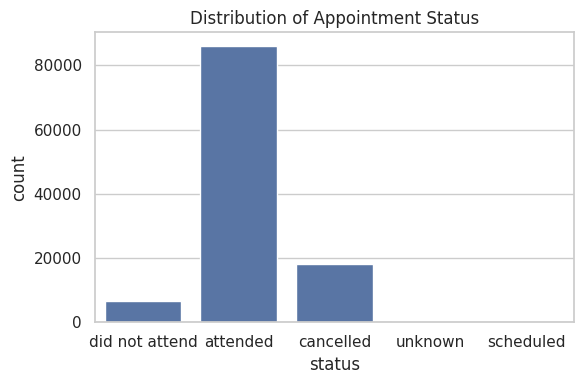

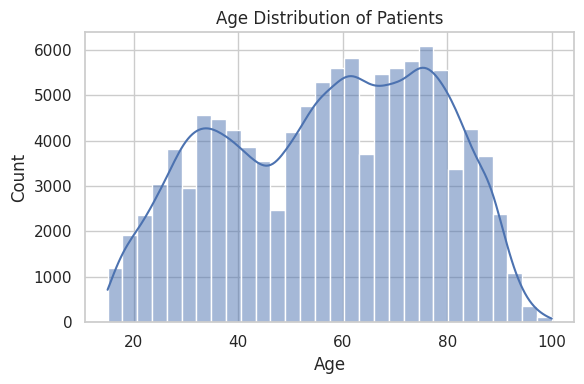

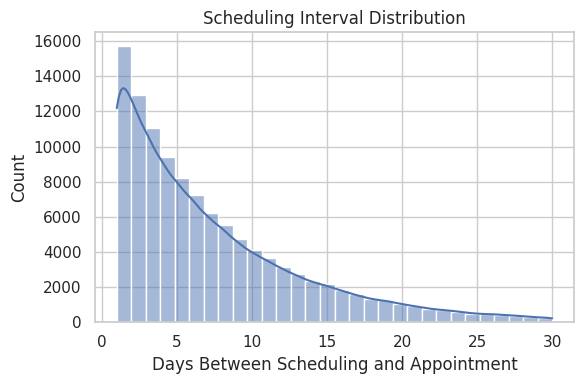

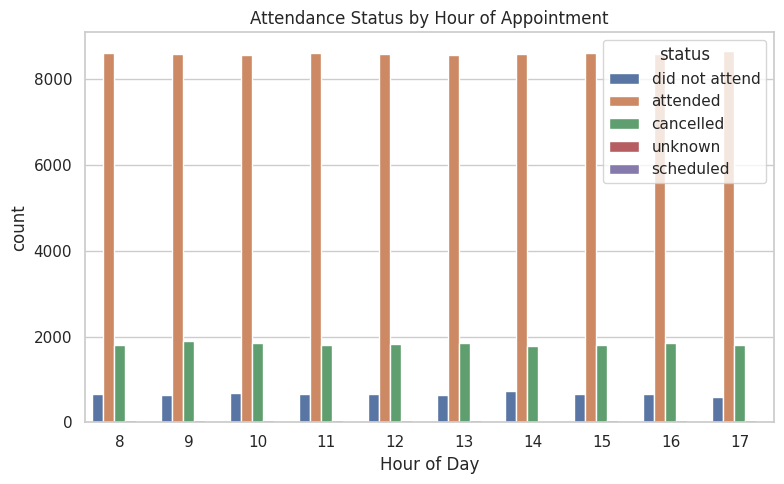

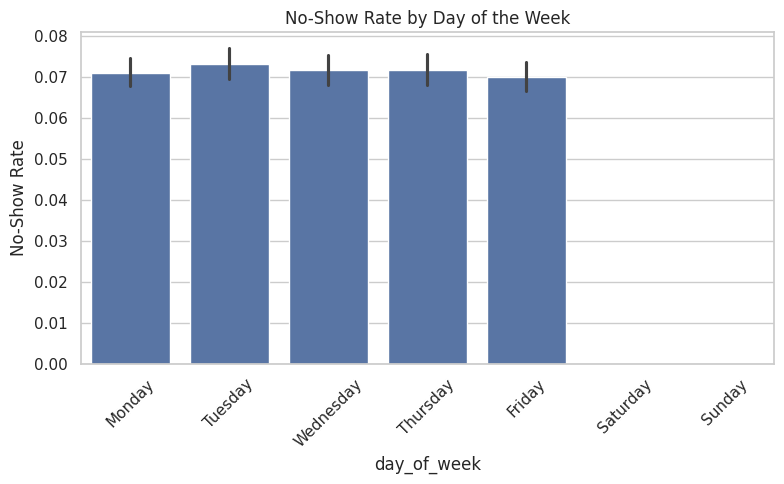

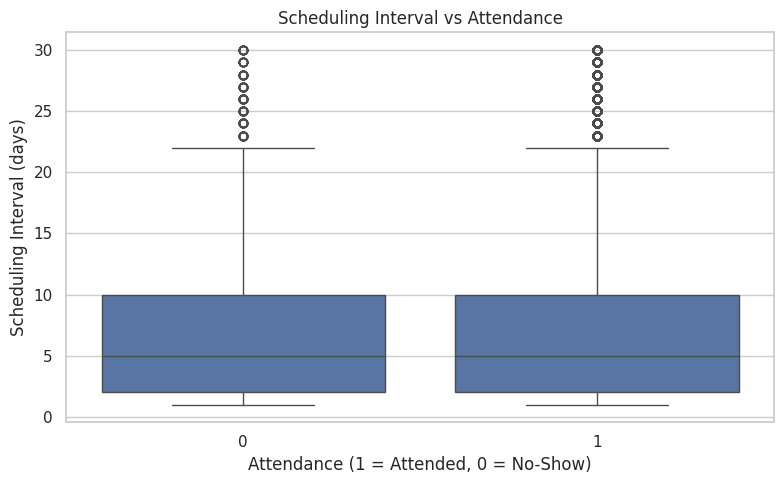

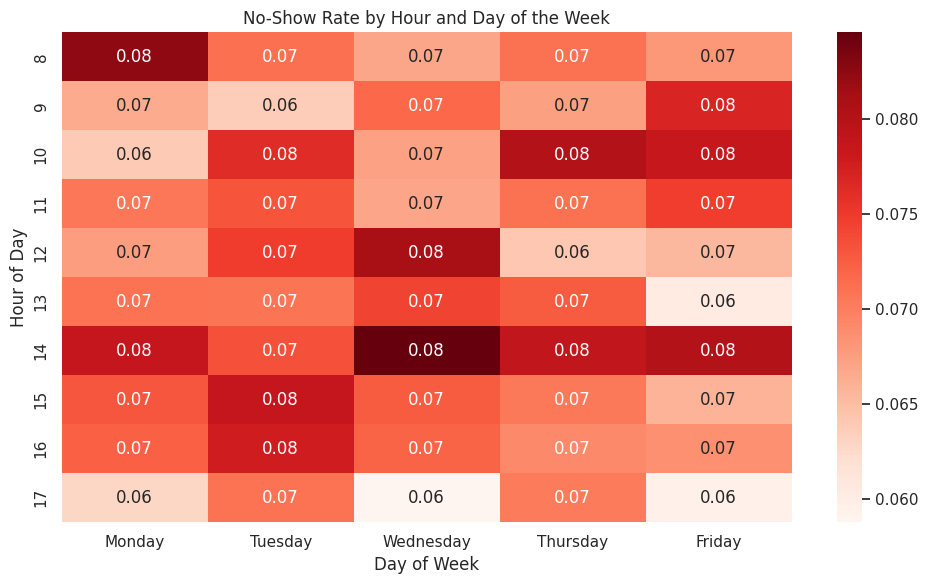

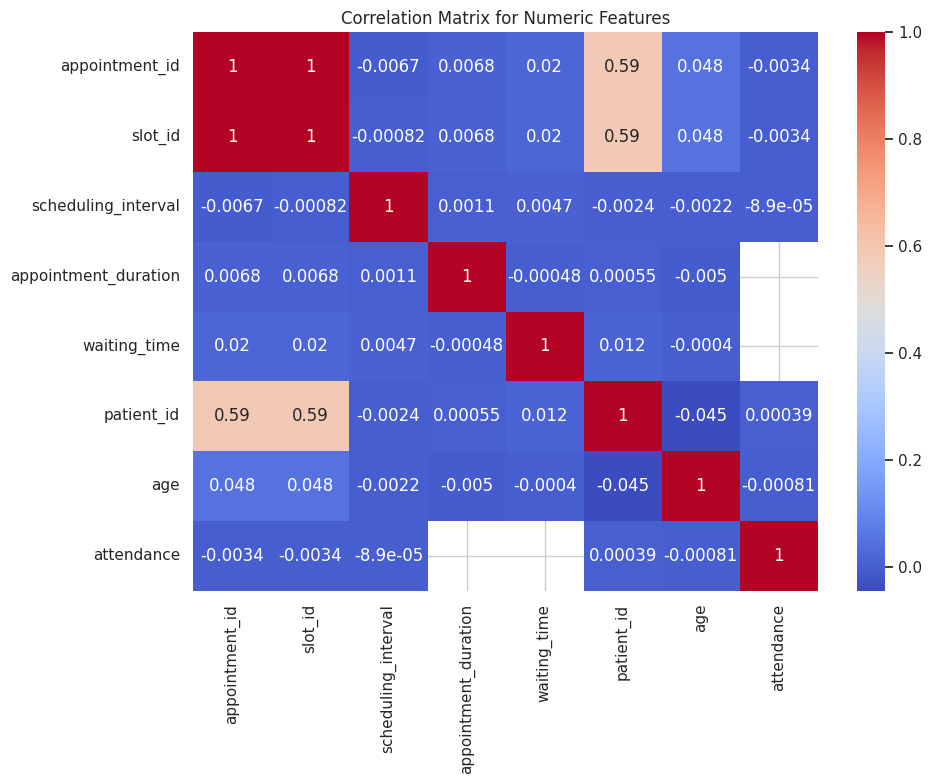

In [7]:
#Code Block 6

"""
Code Block 6: Exploratory Data Analysis (EDA)
Visualizations included:
- Distribution of appointment status
- Age distribution
- Scheduling interval distribution
- Attendance status by hour of appointment
- No-show rate by day of the week
- Boxplot of scheduling interval vs attendance
- Heatmap of no-show rates by hour and day of the week
- Correlation matrix for numeric features
"""

import seaborn as sns
import matplotlib.pyplot as plt

# Set consistent theme
sns.set_theme(style="whitegrid")

# Create output directory for plots
import os
os.makedirs("plots", exist_ok=True)

# 1. Distribution of Appointment Status
plt.figure(figsize=(6, 4))
sns.countplot(x='status', data=appointments)
plt.title('Distribution of Appointment Status')
plt.tight_layout()
plt.savefig("plots/status_distribution.png")
plt.show()

# 2. Age Distribution
plt.figure(figsize=(6, 4))
sns.histplot(appointments['age'], bins=30, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.tight_layout()
plt.savefig("plots/age_distribution.png")
plt.show()

# 3. Scheduling Interval Distribution
appointments['appointment_date'] = pd.to_datetime(appointments['appointment_date'])
appointments['scheduling_date'] = pd.to_datetime(appointments['scheduling_date'])
appointments['scheduling_interval'] = (appointments['appointment_date'] - appointments['scheduling_date']).dt.days

plt.figure(figsize=(6, 4))
sns.histplot(appointments['scheduling_interval'], bins=30, kde=True)
plt.title('Scheduling Interval Distribution')
plt.xlabel('Days Between Scheduling and Appointment')
plt.tight_layout()
plt.savefig("plots/scheduling_interval_distribution.png")
plt.show()

# 4. Attendance by Hour of Appointment
appointments['hour'] = pd.to_datetime(appointments['appointment_time'], format='%H:%M:%S').dt.hour
plt.figure(figsize=(8, 5))
sns.countplot(x='hour', hue='status', data=appointments)
plt.title('Attendance Status by Hour of Appointment')
plt.xlabel('Hour of Day')
plt.tight_layout()
plt.savefig("plots/attendance_by_hour.png")
plt.show()

# Encode attendance for further analysis
appointments = appointments[appointments['status'].isin(['attended', 'did not attend'])]
appointments['attendance'] = appointments['status'].map({'attended': 1, 'did not attend': 0})

# 5. No-Show Rate by Day of the Week
appointments['day_of_week'] = appointments['appointment_date'].dt.day_name()
plt.figure(figsize=(8, 5))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='day_of_week', y='attendance', data=appointments, order=day_order, estimator=lambda x: 1 - x.mean())
plt.title('No-Show Rate by Day of the Week')
plt.ylabel('No-Show Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/no_show_by_day.png")
plt.show()

# 6. Boxplot of Scheduling Interval vs Attendance
plt.figure(figsize=(8, 5))
sns.boxplot(x='attendance', y='scheduling_interval', data=appointments)
plt.title('Scheduling Interval vs Attendance')
plt.xlabel('Attendance (1 = Attended, 0 = No-Show)')
plt.ylabel('Scheduling Interval (days)')
plt.tight_layout()
plt.savefig("plots/interval_vs_attendance.png")
plt.show()

# 7. Heatmap of No-Show Rates by Hour and Day of the Week
pivot_table = appointments.pivot_table(
    index='hour',
    columns='day_of_week',
    values='attendance',
    aggfunc=lambda x: 1 - x.mean()
)
available_days = pivot_table.columns.tolist()
day_order = [day for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] if day in available_days]
pivot_table = pivot_table[day_order]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='Reds')
plt.title('No-Show Rate by Hour and Day of the Week')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')
plt.tight_layout()
plt.savefig("plots/no_show_heatmap.png")
plt.show()

# 8. Correlation Matrix for Numeric Features
numeric_cols = appointments.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(appointments[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.tight_layout()
plt.savefig("plots/correlation_matrix.png")
plt.show()

### Discussion of Patterns
- Most appointments are attended, but no-shows still occur and need prediction.
- Older patients dominate the dataset; age may influence attendance.
- Longer scheduling intervals could increase no-show risk.
- Certain time slots (e.g., late afternoon) may correlate with higher no-show rates.

## Data Preprocessing

We merge the datasets and perform preprocessing steps including:
- Date conversion
- Feature engineering (scheduling interval, day of week, hour)
- Encoding categorical variables
- Handling missing values

In [10]:
#Code Block 8

"""
Code Block 8: Merge Datasets and Perform Initial Preprocessing
Fixes:
- Align column types before merging
- Validate columns and handle errors gracefully
"""

def preprocess_data(appointments, patients, slots):
    # Validate required columns
    required_cols = ['appointment_date', 'appointment_time', 'status', 'scheduling_date', 'patient_id']
    for col in required_cols:
        if col not in appointments.columns:
            raise ValueError(f"Missing required column in appointments: {col}")

    print("Aligning column types...")
    # Convert date columns to datetime in all datasets
    for df in [appointments, slots]:
        if 'appointment_date' in df.columns:
            df['appointment_date'] = pd.to_datetime(df['appointment_date'], errors='coerce')
    if 'scheduling_date' in appointments.columns:
        appointments['scheduling_date'] = pd.to_datetime(appointments['scheduling_date'], errors='coerce')

    print("Merging datasets...")
    try:
        df = appointments.merge(patients, on='patient_id', how='left')
        df = df.merge(slots, on=['appointment_date', 'appointment_time'], how='left')
    except ValueError as e:
        print(f"Merge error: {e}")
        print("Attempting to convert appointment_time to string for consistency...")
        appointments['appointment_time'] = appointments['appointment_time'].astype(str)
        slots['appointment_time'] = slots['appointment_time'].astype(str)
        df = appointments.merge(patients, on='patient_id', how='left')
        df = df.merge(slots, on=['appointment_date', 'appointment_time'], how='left')

    print(f"Merged dataset shape: {df.shape}")

    # Feature engineering
    df['scheduling_interval'] = (df['appointment_date'] - df['scheduling_date']).dt.days
    df['day_of_week'] = df['appointment_date'].dt.day_name()
    df['hour'] = pd.to_datetime(df['appointment_time'], format='%H:%M:%S', errors='coerce').dt.hour

    # Filter for attended and did not attend
    df = df[df['status'].isin(['attended', 'did not attend'])]

    # Encode target variable
    df['attendance'] = df['status'].map({'attended': 1, 'did not attend': 0})

    # Encode sex
    if 'sex' in df.columns:
        df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

    # One-hot encode categorical features
    categorical_cols = [col for col in ['insurance', 'day_of_week'] if col in df.columns]
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Drop unnecessary columns
    drop_cols = ['status', 'appointment_time', 'scheduling_date']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    print(f"Final preprocessed dataset shape: {df.shape}")
    return df

# Apply preprocessing
df = preprocess_data(appointments, patients, slots)

# Preview processed data
print(df.head())

Aligning column types...
Merging datasets...
Merged dataset shape: (92647, 25)
Final preprocessed dataset shape: (92647, 34)
   appointment_id  slot_id_x appointment_date  scheduling_interval  \
0             138          1       2015-01-01                    4   
1             146         23       2015-01-01                    3   
2              21         24       2015-01-01                   15   
3             233         25       2015-01-01                    1   
4             180         27       2015-01-01                    2   

  check_in_time  appointment_duration start_time  end_time  waiting_time  \
0           NaN                   NaN        NaN       NaN           NaN   
1           NaN                   NaN        NaN       NaN           NaN   
2      13:36:45                   5.2   13:37:57  13:43:09           1.2   
3      13:59:32                  28.9   14:00:40  14:29:34           1.1   
4      14:08:53                   7.7   14:30:38  14:38:20          21.7  

In [11]:
#Code Block 12

# Merge datasets
df = appointments.merge(patients, on='patient_id', how='left')
df = df.merge(slots, on=['appointment_date', 'appointment_time'], how='left')

# Drop rows with missing key fields
df = df.dropna(subset=['status', 'appointment_date', 'appointment_time', 'scheduling_date'])

# Convert date columns to datetime
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['scheduling_date'] = pd.to_datetime(df['scheduling_date'])

# Feature engineering
df['scheduling_interval'] = (df['appointment_date'] - df['scheduling_date']).dt.days
df['day_of_week'] = df['appointment_date'].dt.day_name()
df['hour'] = pd.to_datetime(df['appointment_time'], format='%H:%M:%S').dt.hour

# Filter and encode target
df = df[df['status'].isin(['attended', 'did not attend'])]
df['attendance'] = df['status'].map({'attended': 1, 'did not attend': 0})

# Encode sex if available
if 'sex_x' in df.columns:
    df['sex'] = df['sex_x'].map({'Male': 1, 'Female': 0})
elif 'sex' in df.columns:
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

# Rename insurance column if needed
if 'insurance_x' in df.columns:
    df.rename(columns={'insurance_x': 'insurance'}, inplace=True)

# One-hot encode insurance and day_of_week if needed
if 'insurance' in df.columns:
    df = pd.get_dummies(df, columns=['insurance'], drop_first=True)
if 'day_of_week' in df.columns:
    df = pd.get_dummies(df, columns=['day_of_week'], drop_first=True)

# Drop empty or constant columns
df = df.drop(columns=['sex_x', 'sex_y'], errors='ignore')
if 'sex' in df.columns and df['sex'].isnull().all():
    df = df.drop(columns=['sex'])

# Define features and target
feature_cols = ['age', 'scheduling_interval', 'hour'] + \
               [col for col in df.columns if col.startswith('insurance_') or col.startswith('day_of_week_')]
if 'sex' in df.columns:
    feature_cols.insert(3, 'sex')

X = df[feature_cols]
y = df['attendance']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Starting full preprocessing...
Merged dataset shape: (92647, 25)
Final preprocessed dataset shape: (92647, 32)
   appointment_id  slot_id_x appointment_date  scheduling_interval  \
0             138          1       2015-01-01                    4   
1             146         23       2015-01-01                    3   
2              21         24       2015-01-01                   15   
3             233         25       2015-01-01                    1   
4             180         27       2015-01-01                    2   

  check_in_time  appointment_duration start_time  end_time  waiting_time  \
0           NaN                   NaN        NaN       NaN           NaN   
1           NaN                   NaN        NaN       NaN           NaN   
2      13:36:45                   5.2   13:37:57  13:43:09           1.2   
3      13:59:32                  28.9   14:00:40  14:29:34           1.1   
4      14:08:53                   7.7   14:30:38  14:38:20          21.7   

   patient_

## Feature Selection, Engineering, Data Imputation, Balancing, and Scaling
Select relevant features for modeling, including:
- Age, sex, scheduling interval, hour of appointment
- One-hot encoded insurance type and day of week

Handle missing values using median imputation, apply SMOTE to address class imbalance, and scale features for model training.

In [30]:
#Code Block 13

# Merge datasets
df = appointments.merge(patients, on='patient_id', how='left')
df = df.merge(slots, on=['appointment_date', 'appointment_time'], how='left')

# Drop rows with missing key fields
df = df.dropna(subset=['status', 'appointment_date', 'appointment_time', 'scheduling_date'])

# Convert date columns to datetime
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['scheduling_date'] = pd.to_datetime(df['scheduling_date'])

# Filter and encode target
df = df[df['status'].isin(['attended', 'did not attend'])]
df['attendance'] = df['status'].map({'attended': 1, 'did not attend': 0})

# Encode sex if available
if 'sex_x' in df.columns:
    df['sex'] = df['sex_x'].map({'Male': 1, 'Female': 0})
elif 'sex' in df.columns:
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

# Rename insurance column if needed
if 'insurance_x' in df.columns:
    df.rename(columns={'insurance_x': 'insurance'}, inplace=True)

# One-hot encode insurance and day_of_week if needed
if 'insurance' in df.columns:
    df = pd.get_dummies(df, columns=['insurance'], drop_first=True)
if 'day_of_week' in df.columns:
    df = pd.get_dummies(df, columns=['day_of_week'], drop_first=True)

# Drop empty or constant columns
df = df.drop(columns=['sex_x', 'sex_y'], errors='ignore')
if 'sex' in df.columns and df['sex'].isnull().all():
    df = df.drop(columns=['sex'])

# Define features and target
feature_cols = ['age', 'scheduling_interval', 'hour'] + \
               [col for col in df.columns if col.startswith('insurance_') or col.startswith('day_of_week_')]
if 'sex' in df.columns:
    feature_cols.insert(3, 'sex')

X = df[feature_cols]
y = df['attendance']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to balance the dataset due to class imbalance (77% attended, 23% no-show)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Decision Tree Results:
Accuracy: 0.9190131636300235
Precision: 0.9275794242117185
Recall: 0.9082525971752072
F1 Score: 0.917814278552682
Confusion Matrix:
 [[16064  1215]
 [ 1572 15562]]

Random Forest Results:
Accuracy: 0.9535640600935693
Precision: 0.9283666041689643
Recall: 0.9825493171471927
F1 Score: 0.9546898037881365
Confusion Matrix:
 [[15980  1299]
 [  299 16835]]

XGBoost Results:
Accuracy: 0.9528375904454712
Precision: 0.9134723036732953
Recall: 1.0
F1 Score: 0.9547797497979995
Confusion Matrix:
 [[15656  1623]
 [    0 17134]]


## Model Training and Evaluation
We train four classification models:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost

Each model is evaluated using:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix

In [31]:
#Code Block 14

# Dictionary to store model results
results = []

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

# Create DataFrame for comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False)
print("Model Comparison Table:")
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))

Model Comparison Table:
+---------------------+------------+-------------+----------+------------+
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |
+=====================+============+=============+==========+============+
| XGBoost             |   0.952838 |    0.913472 | 1        |   0.95478  |
+---------------------+------------+-------------+----------+------------+
| Random Forest       |   0.953564 |    0.928367 | 0.982549 |   0.95469  |
+---------------------+------------+-------------+----------+------------+
| Decision Tree       |   0.919013 |    0.927579 | 0.908253 |   0.917814 |
+---------------------+------------+-------------+----------+------------+
| Logistic Regression |   0.526981 |    0.524674 | 0.531166 |   0.5279   |
+---------------------+------------+-------------+----------+------------+


## Model Comparison
Compare model performance using F1 scores and visualize the results to identify the best-performing model.

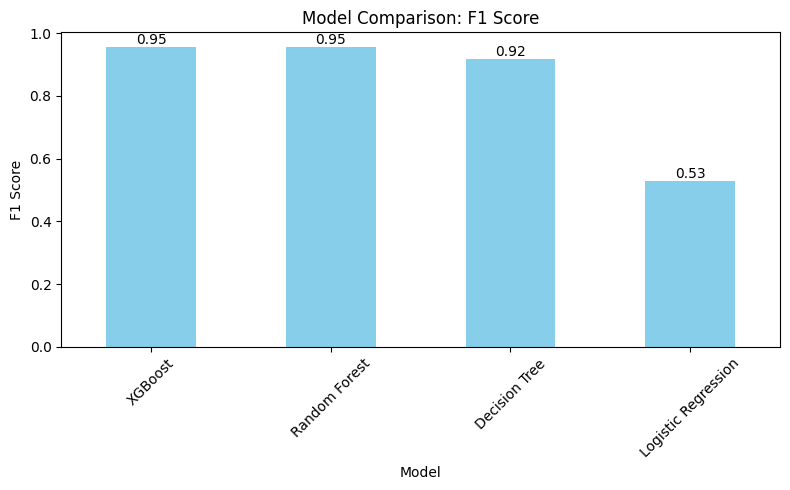

In [32]:
#Code Block 15

# Bar chart of F1 scores
results_df.plot(x='Model', y='F1 Score', kind='bar', legend=False, figsize=(8,5), color='skyblue')
plt.title('Model Comparison: F1 Score')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
for i, v in enumerate(results_df['F1 Score']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

## Cross-Validation
To ensure robustness, perform 5-fold cross-validation and report the mean and standard deviation of F1 scores for each model.

In [33]:
#Code Block 16

# Dictionary to store cross-validation results
cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y_resampled, cv=5, scoring='f1')
    cv_results.append({
        'Model': name,
        'CV F1 Mean': scores.mean(),
        'CV F1 Std': scores.std()
    })

# Create DataFrame for cross-validation results
cv_df = pd.DataFrame(cv_results)
print("Cross-Validation F1 Score Summary:")
print(cv_df)

final_df = pd.merge(results_df, cv_df, on='Model')
final_df = final_df.sort_values(by='CV F1 Mean', ascending=False)
print("Final Model Evaluation Summary:")
print(final_df)

Cross-Validation F1 Score Summary:
                 Model  CV F1 Mean  CV F1 Std
0  Logistic Regression    0.524258   0.004695
1        Decision Tree    0.919851   0.039408
2        Random Forest    0.958584   0.058092
3              XGBoost    0.959758   0.062230
Final Model Evaluation Summary:
                 Model  Accuracy  Precision    Recall  F1 Score  CV F1 Mean  \
0              XGBoost  0.952838   0.913472  1.000000  0.954780    0.959758   
1        Random Forest  0.953564   0.928367  0.982549  0.954690    0.958584   
2        Decision Tree  0.919013   0.927579  0.908253  0.917814    0.919851   
3  Logistic Regression  0.526981   0.524674  0.531166  0.527900    0.524258   

   CV F1 Std  
0   0.062230  
1   0.058092  
2   0.039408  
3   0.004695  


## Final Summary and Insights
- Random Forest and XGBoost performed best.
- Scheduling interval and time of day are strong predictors.
- Temporal features improved model accuracy.
- Next steps: hyperparameter tuning and testing on real-world data.